In [2]:
import os

def rename_images(folder_path, prefix="image_"):
    # Lấy danh sách tất cả các tệp trong thư mục
    images = os.listdir(folder_path)

    # Sắp xếp tên tệp để đảm bảo thứ tự
    images.sort()

    # Vòng lặp qua tất cả các tệp và đổi tên chúng
    for index, img_name in enumerate(images):
        # Lấy phần mở rộng của ảnh (ví dụ: .jpg, .png)
        ext = os.path.splitext(img_name)[1]

        # Tạo tên mới cho tệp
        new_name = f"{prefix}{index + 1}{ext}"

        # Đường dẫn tệp cũ
        old_path = os.path.join(folder_path, img_name)

        # Đường dẫn tệp mới
        new_path = os.path.join(folder_path, new_name)

        # Đổi tên tệp
        os.rename(old_path, new_path)
        print(f"Đã đổi tên: {img_name} -> {new_name}")

# Đường dẫn đến thư mục chứa ảnh
folder_path = 'C:/Downloads/Image-Colorization2-main/Data/colored/'

# Đổi tên ảnh với tiền tố (prefix) là "image_"
rename_images(folder_path)


Đã đổi tên: 1000.jpg -> image_1.jpg
Đã đổi tên: 1005.jpg -> image_2.jpg
Đã đổi tên: 1015.jpg -> image_3.jpg
Đã đổi tên: 1023.jpg -> image_4.jpg
Đã đổi tên: 1030.jpg -> image_5.jpg
Đã đổi tên: 1033.jpg -> image_6.jpg
Đã đổi tên: 104.jpg -> image_7.jpg
Đã đổi tên: 1056.jpg -> image_8.jpg
Đã đổi tên: 1059.jpg -> image_9.jpg
Đã đổi tên: 106.jpg -> image_10.jpg
Đã đổi tên: 1073.jpg -> image_11.jpg
Đã đổi tên: 1077.jpg -> image_12.jpg
Đã đổi tên: 1078.jpg -> image_13.jpg
Đã đổi tên: 108.jpg -> image_14.jpg
Đã đổi tên: 1088.jpg -> image_15.jpg
Đã đổi tên: 1094.jpg -> image_16.jpg
Đã đổi tên: 1099.jpg -> image_17.jpg
Đã đổi tên: 1100.jpg -> image_18.jpg
Đã đổi tên: 1120.jpg -> image_19.jpg
Đã đổi tên: 1121.jpg -> image_20.jpg
Đã đổi tên: 1122.jpg -> image_21.jpg
Đã đổi tên: 113.jpg -> image_22.jpg
Đã đổi tên: 1134.jpg -> image_23.jpg
Đã đổi tên: 1139.jpg -> image_24.jpg
Đã đổi tên: 1142.jpg -> image_25.jpg
Đã đổi tên: 1146.jpg -> image_26.jpg
Đã đổi tên: 1167.jpg -> image_27.jpg
Đã đổi tên: 11

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import img_to_array, load_img
from skimage import color
from skimage.color import lab2rgb, rgb2lab
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import os

# Tạo lớp để tải dữ liệu theo lô
class ImageDataGeneratorWithLabels(Sequence):
    def __init__(self, gray_folder_path, color_folder_path, batch_size=16, img_size=(256, 256)):
        self.gray_folder_path = gray_folder_path
        self.color_folder_path = color_folder_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.gray_images = os.listdir(gray_folder_path)
        self.color_images = os.listdir(color_folder_path)

    def __len__(self):
        return int(np.ceil(len(self.gray_images) / self.batch_size))

    def __getitem__(self, index):
        batch_gray = self.gray_images[index * self.batch_size:(index + 1) * self.batch_size]
        batch_color = self.color_images[index * self.batch_size:(index + 1) * self.batch_size]

        X_batch = []
        Y_batch = []

        for gray_img, color_img in zip(batch_gray, batch_color):
            gray_path = os.path.join(self.gray_folder_path, gray_img)
            color_path = os.path.join(self.color_folder_path, color_img)

            # Tải và tiền xử lý ảnh grayscale
            img_gray = load_img(gray_path, target_size=self.img_size)
            img_gray = img_to_array(img_gray) / 255
            X_batch.append(color.rgb2gray(img_gray))

            # Tải và tiền xử lý ảnh màu
            img_color = load_img(color_path, target_size=self.img_size)
            img_color = img_to_array(img_color) / 255
            lab_image = rgb2lab(img_color)
            lab_image_norm = (lab_image + [0, 128, 128]) / [100, 255, 255]
            Y_batch.append(lab_image_norm[:, :, 1:])  # Giữ lại chỉ các kênh AB

        return np.array(X_batch, dtype=np.float32), np.array(Y_batch, dtype=np.float32)

# Đường dẫn đến thư mục chứa ảnh
gray_folder_path = 'D:/Workspace python/ImageConverter/landscape Images/gray/'
color_folder_path = 'D:/Workspace python/ImageConverter/landscape Images/color/'

# Khởi tạo trình tạo dữ liệu
train_data_gen = ImageDataGeneratorWithLabels(gray_folder_path, color_folder_path)

# Xây dựng mô hình
input_layer = Input(shape=(256, 256, 1))

# Các lớp tích chập
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

# Tăng kích thước và các lớp bổ sung
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

# Lớp đầu ra với 2 kênh (kênh AB)
output_layer = Conv2D(2, (3, 3), activation='sigmoid', padding='same')(x)

# Hoàn thiện mô hình
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Biên dịch mô hình
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')

# Dừng sớm để ngăn ngừa overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit mô hình sử dụng trình tạo dữ liệu
model.fit(train_data_gen, epochs=100, callbacks=[early_stopping])

# Đánh giá mô hình
# model.evaluate(X, Y, batch_size=16)


Epoch 1/100


c:\python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


465/486 ━━━━━━━━━━━━━━━━━━━━ 11:56 34s/step - loss: 0.0092

In [5]:
# Save the model in TensorFlow SavedModel format
model.save('colorization_model1.keras')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


C:\Users\Admin\AppData\Local\Temp\ipykernel_16952\527564925.py:32: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 5 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(outputLAB)


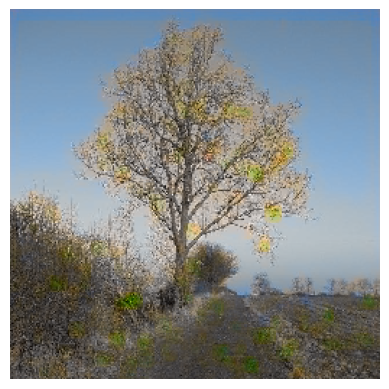

In [13]:
import numpy as np
import os
from keras.preprocessing.image import img_to_array, load_img
from skimage.color import lab2rgb
import matplotlib.pyplot as plt

# Testing the model with a higher resolution image
folder_path = 'C:/Downloads/Image-Colorization2-main/Data/Test/'
img_name = 'Gray_rural44.jpg'
img_path = os.path.join(folder_path, img_name)

# Load and preprocess grayscale image with higher resolution
img = load_img(img_path, target_size=(256, 256), color_mode="grayscale")
img = img_to_array(img) / 255
X_test = np.expand_dims(img, axis=-1)  # Add channel dimension
X_test = np.reshape(X_test, (1, 256, 256, 1))  # Resize to (1, 256, 256, 1)

# Predict and reshape the output
output = model.predict(X_test)
output = np.reshape(output, (256, 256, 2))  # Resize to (256, 256, 2)

# Create the LAB image with higher resolution
outputLAB = np.zeros((256, 256, 3))  # Keep it at (256, 256)
img = np.reshape(img, (256, 256))  # Reshape input image to match LAB L channel
outputLAB[:, :, 0] = img  # L channel
outputLAB[:, :, 1:] = output  # AB channels

# Normalize back to LAB space
outputLAB = (outputLAB * [100, 255, 255]) - [0, 128, 128]

# Convert back to RGB space
rgb_image = lab2rgb(outputLAB)

# Show the output image
plt.imshow(rgb_image)
plt.axis('off')
plt.show()
